## Stardist compute receptive field (3D)

NOTE: This is similar to the ```stardist_receptive_field_2D``` example.  It is not the 'dryest' approach to have two very similar notebooks, however since the notebooks for the course are also used to prototype and choose the network parameters, I think it is useful to have the 3D version separate (so someone can run it and understand it without it being cluttered with if statements).

Also there are memory-related issues when trying to test very large 3D networks on GPUs thus it is better to run this notebook on a CPU if a large GPU is not available. 

When trying to train a stardist model it is useful to check if the configured neural network has a large enough field of view to detect the objects in the images.  This [stardist 3D training example notebook](https://github.com/stardist/stardist/blob/master/examples/3D/2_training.ipynb) from the ```stardist``` github repo, is a great starting point for creating customized stardist workflows.  It contains the below code snippet to calculate the network field of view.

```
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")
```

A small issue, it may make more sense to calculate the max extent, rather than median.  Another issue is that the field of view appears to max out at 32 in all dimensions.  Try creating a network that has a larger field of view and you still get 32.

This notebook looks into the stardist 'field of view' calculation in a little more detail, with the goal to compute larger 3D field of view values. 

### First our imports

In [1]:
from stardist.models import Config3D, StarDist3D
import raster_geometry as rg
from stardist import Rays_GoldenSpiral, Rays_Octo
from tnia.plotting.projections import show_xy_zy_max
from stardist import calculate_extents
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Make GPU invisible to tensorflow

We do this because (as is shown downstream in this notebook) the receptive field calculation can use a lot of GPU memory when calculating large RFs, and sometimes the GPU crashes.  The CPU has more memory, so we use it (even though the calculation will take a bit longer).

In [2]:
tf.config.set_visible_devices([], 'GPU')

## Create a 3D simulated object

This is just a circle and a sphere.  Make the sphere bigger if you want to design a network for bigger objects.  In a real project we'd have labels with many objects in them.  Here we just use this very simple 'label' as an example of the biggest object we want the system to handle.  

xy_pixels_radius 100, z_pixels_radius, 33


Text(0.5, 0.98, 'ellipsoid')

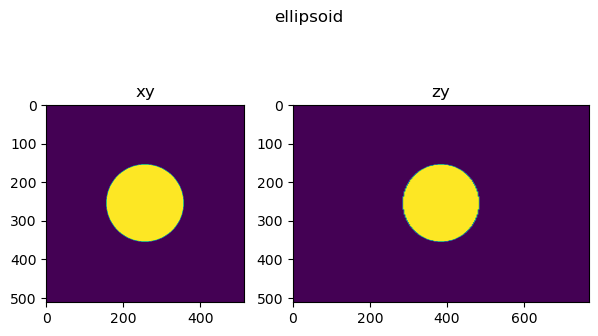

In [3]:
radius = 100
image_size = [256, 512, 512]

xy_spacing = 1
z_spacing = 3

xy_pixels_radius = int(radius / xy_spacing)
z_pixels_radius = int(radius / z_spacing)

print(f'xy_pixels_radius {xy_pixels_radius}, z_pixels_radius, {z_pixels_radius}')

ellipsoid = rg.ellipsoid(image_size, [z_pixels_radius, xy_pixels_radius, xy_pixels_radius]).astype('uint8')

fig = show_xy_zy_max(ellipsoid, sxy=xy_spacing, sz=z_spacing, figsize=(7,4))
fig.suptitle('ellipsoid')

### Calculate the extent and anisotropy of our sphere

In [4]:
extents = calculate_extents(ellipsoid)
anisotropy = tuple(np.max(extents) / extents)

print('extends 3D',extents)
print('anisotropy 3D',anisotropy)

extends 3D [ 66. 200. 200.]
anisotropy 3D (3.0303030303030303, 1.0, 1.0)


### Design a stardist 3D network

We make the model_name 'delete me' because we aren't going to train it or anything, so we want delete it after we are done. Then we need to define the ```grid```, ```unet_kernel_size```, and ```depth```.  These parameters determine the receptive field. 

1.  A larger 'grid' means the filter takes a larger stride at the first level, thus 'see's more'
2.  A larger kernel size means the network 'see's more' at each level.
3.  At each level the images are downsampled, which means when we apply the kernels at that level they porcess information from a larger spatial extent.  


In [5]:
rays = Rays_Octo(n_level=1) 

model_name = 'delete me 3D'
grid = (1,1,1)
unet_kernel_size=3, 3, 3
unet_n_filter_base = 3
depth = 3
n_channel_in =1
axes = 'ZYX'

config = Config3D (rays=rays, axes=axes,n_channel_in=1, train_patch_size = (32,128,128), anisotropy=anisotropy, grid=grid, unet_n_depth=depth, unet_kernel_size=unet_kernel_size, unet_n_filter_base=unet_n_filter_base)

model = StarDist3D(config=config, name=model_name, basedir='models')


base_model.py (149): output path for model already exists, files may be overwritten: C:\Users\bnort\work\ImageJ2022\tnia\deconvolution-gpu-dl-course\docs\30_deep_learning\models\delete me 3D


Using default values: prob_thresh=0.5, nms_thresh=0.4.


### Apply the example 'field of view' code

Note we make a couple of changes.  First we use max size instead of median.  Second we also compute receptive field.  

```
rf = model._compute_receptive_field(img_size=(256, 512, 512))
```

In retrospect it was a bit strange that we use a function called ```_axes_tile_overlap``` to calculate receptive field.  However if you inspect the code, ```_axes_tile_overlap``` did wrap ```_compute_receptive_field```.  However using ```_compute_receptive_field``` directly allows us to input an ```img_size```.

That is really important.  Stardist calculates the receptive field by applying the real network and empirically measuring how much of the result contains 'information'.  If you use a small image size like 64, 64, 64 the entire image will contain information.  Basically you need to make your ```img_size``` larger than the receptive field you expect.

In [6]:
max_size = calculate_extents(ellipsoid, np.max)
fov = np.array(model._axes_tile_overlap('ZYX'))
rf = model._compute_receptive_field(img_size=(256, 512, 512))
print(f"max object size:      {max_size/2}")
print(f"network field of view :  {fov}")
print(f"receptive field :  {rf}")
#if any(max_size > rf):
#    print("WARNING: max object size larger than field of view of the neural network.")

max object size:      [ 33. 100. 100.]
network field of view :  [32 32 32]
receptive field :  [(47, 46), (47, 46), (47, 46)]


### Look at the receptive filed function step by step

1.  It generates two images, an empty image, and an impulse response.  This is really cool.   An impulse response is how engineers measure the Point Spread Function of a system.  Note that for a neural network the impulse response is non-linear, however we aren't concerned about the exact shape (this network hasn't even been trained) but only concerned about 'how far' information propagates. 

In [7]:
img_size = (256, 512, 512)
mid = tuple(s//2 for s in img_size)
x = np.zeros((1,)+img_size+(1,), dtype=np.float32)
z = np.zeros_like(x)
x[(0,)+mid+(slice(None),)] = 1

## Make predictions with our inputs

Our inputs are an impulse and an empty image, the output is the 'impulse response' and the offset.

In [8]:
y  = model.keras_model.predict(x, verbose=0)[0][0,...,0]
y0 = model.keras_model.predict(z, verbose=0)[0][0,...,0]
dif = np.abs(y-y0)

### calculate distance information 'flowed'

In [20]:
from scipy.ndimage import zoom
print(grid)
yz  = zoom(y, grid,order=0)
y0z = zoom(y0,grid,order=0)
ind = np.where(np.abs(y-y0)>0)

mid = tuple(s//2 for s in img_size)

for i,m in zip(ind,mid):
     print(np.min(i), np.max(i), m-np.min(i), np.max(i)-m)


(1, 1, 1)
81 174 47 46
209 302 47 46
209 302 47 46


## View in Napari

We look at the 'dif' image as it shows us what parts of the image have information that is different than the constant value resulting form an empty input. 

In [21]:
import napari
viewer = napari.Viewer()
viewer.add_image(dif.squeeze()>0, name='dif')
viewer.add_labels(ellipsoid, name='ellipsoid')

napari.manifest -> 'napari-hello' could not be imported: Cannot find module 'napari_plugins' declared in entrypoint: 'napari_plugins:napari.yaml'


<Labels layer 'ellipsoid' at 0x1c56c4a5520>

In [30]:
dif.shape

(256, 256, 256)